# Assignment 2 - Leonardo Stoppani

# Image Classification with Convolutional Neural Networks on CIFAR-10

## Define and train the model 

For this assignment i choose to use the `keras` library since it offers a straightforward API to build and train CNNs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from pprint import pprint


### Data preparation

First the dataset is loaded from keras datasets with the `load_data()` function. Then train data are splitted into training and validation with `sklearn` function `train_test_split()`. From this point only training and validation data will be used to train the model, test data will be used only to evaluate the final model and give an accuracy score.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

print(X_train.shape, X_val.shape, X_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


Labels are converted to one-hot encoding with `keras.utils.to_categorical()` to exploit the distribution learning capabilities of the model. Also images are normalized to have values between 0 and 1.

In [4]:
# one hot encode target values
train_labels = to_categorical(y_train, num_classes=10)
val_labels = to_categorical(y_val, num_classes=10)
test_labels = to_categorical(y_test, num_classes=10)

# normalize pixel values
train_images = X_train.astype('float32') / 255
val_images = X_val.astype('float32') / 255
test_images = X_test.astype('float32') / 255

Just a look to the dataset.

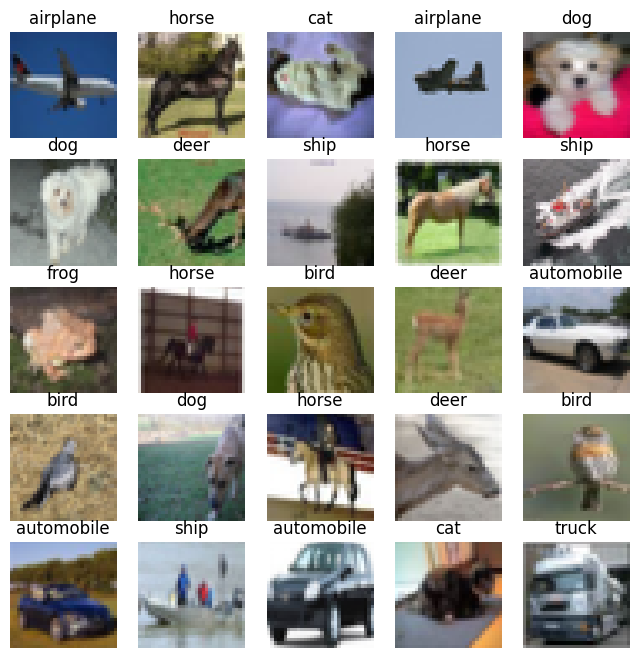

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
                'horse', 'ship', 'truck']

fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(train_images[i])
    # show labels from one hot to categorical
    ax.set_title(class_names[np.argmax(train_labels[i])])
    ax.axis('off')
plt.show()


### Data augmentation
To achieve better results, data augmentation is performed using the keras class `ImageDataGenerator` which apply random transformations to the images. This will allow the model to generalize better, and to be more robust to different transformations of the input images, working as regularization.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
datagen.fit(train_images)

### Define the CNN architecture
The model architecture is made of 3 convolutional layers with 32, 64 and 128 filters respectively, followed by a fully connected layer with 256 units and a softmax output layer with 10 units. The convolutional layers use a 3x3 kernel and a stride of 1, the activation function used is ReLU and the max pooling is performed with a 2x2 kernel. To regularize the model, dropout is applied after each convolutional layer and after the fully connected layer with a rate of 0.2.

Different architectures have been tested, but this one had the best tradeoff between accuracy and complexity. State of the art results on CIFAR-10 are achieved with more parameters, 5 and more convolutional layers are used, with more filters and a larger fully connected layer. ResNet achieve 99% of accuracy with over 25 million parameters [[1]](https://paperswithcode.com/sota/image-classification-on-cifar-10?tag_filter=3). I try to keep the number of parameters contained to reduce the time of training, in order to perform more experiments and see if i could achieve good results with a simpler model.

Dropout and data augmentation were key factors to avoid overfitting and keep the training and validation accuracy close until the end of the training. Without these techniques, the model was overfitting and could not achieve more than 77% accuracy in validation.

The final model has 620.362 parameters, it takes about 20 minutes to train on a GPU and is able to reach 83% accuracy on the test set.

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 64)         

### Train the model
The model is trained for 100 epochs, with a batch size of 128, using the Adam optimizer with a learning rate of 0.001. The loss function used is categorical crossentropy, and the metric used to evaluate the model is accuracy. After training the model for 100 epochs the model was not overfitting so i decide to continue training for 50 more epochs. Early Stopping halt the training after 130 epochs, when the validation loss stopped improving.

Adam optimizer is used with default parameters. The learning rate is set to 0.001, it is a good value for Adam, and it is not too high to cause the model to diverge. The learning curve is a bit noisy, but make sense with Adam, because it is able to adapt the learning rate for each parameter, so it is normal to see some spikes in the loss curve.

The following cell are commented because the model is already trained and saved, so it is not necessary to train it again.

In [53]:
adam = keras.optimizers.legacy.Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

#model.compile(optimizer=adam,
#              loss=tf.keras.losses.CategoricalCrossentropy(),
#              metrics=['accuracy'])

In [54]:
tf.device('/device:GPU:0')

early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True, mode='min')

# tensorboard callback
! rm -rf ./logs/
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

#history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
#                    epochs=100,
#                    validation_data=(val_images, val_labels),
#                    callbacks=[early_stopping, tensorboard_callback])

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True, mode='min')

# history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
#                    epochs=50,
#                    validation_data=(val_images, val_labels),
#                    callbacks=[early_stopping, tensorboard_callback])


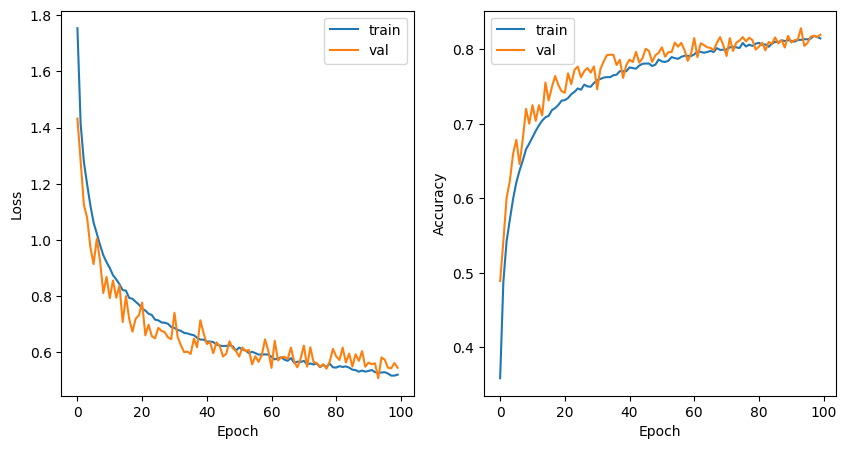

In [57]:
# plot loss and accuracy of validation and training data in subplots
#plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='val')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend()
#plt.subplot(1,2,2)
#plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='val')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

from IPython.display import Image
Image(filename='lc.png')

In [ ]:
# save the model with unique name based on number of parameters and validation accuracy
#model.save(f'cifar10_model_{model.count_params()}_{round(history.history["val_accuracy"][-1], 2)}.h5')

### Evaluate model on test set
Evaluating the model on test images shows an accuracy of 83,23%.

In [6]:
model = models.load_model('cifar10_model_620362_0.83.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc*100:.2f}%')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-12 11:27:06.718861: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 - 3s - loss: 0.5198 - accuracy: 0.8323 - 3s/epoch - 9ms/step
Test accuracy: 83.23%


Confusion matrix shows that the model is able to classify most of the images correctly. However, it makes mistake on image wich represent similar category. An obvious case is the one of `cat` and `dog`, the number of dog predicted as cat is 123. Cat and dogs, truck and automobile, have similar features that causes misclassifications, a way to improve model performance could be to add the number of filter, so that the model can learn more complex features.

313/313 [==============================] - 1s 3ms/step


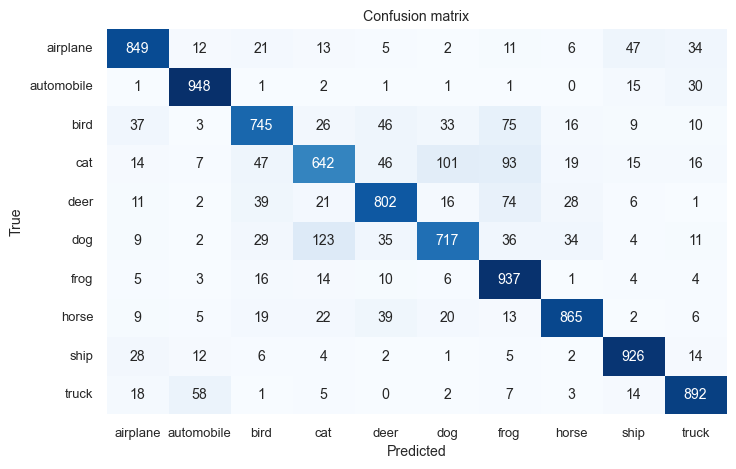

In [23]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
# label size
sns.set(font_scale=0.85)
plt.tight_layout()
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The above image shows an example of dog misclassified as a cat.

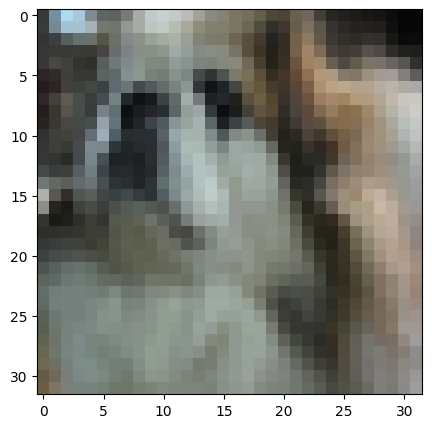

cat: 0.49747562408447266
dog: 0.4709009528160095
horse: 0.01591530069708824
bird: 0.007559230085462332
deer: 0.004406760912388563


In [21]:
plt.figure(figsize=(5, 5))
plt.imshow(test_images[7258])
plt.show()

# predict class of random image
prediction = model.predict(test_images[7258].reshape(1, 32, 32, 3), verbose=0)

# ptint the first 5 class labels with highest probability
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

## Test with occlusions

Now that we have the final model, we can test it with occluded images. First we define a function `patch_image()` that take an image as input and return the same image with a gray patch of `nxn` size. The function allows also to specify the position of the patch with the `x` and `y` parameters. 

The idea is to look at the confusion matrix and choose the most confused classes, then occlude the images of the test set with a patch of different size and position, and see how the model perform on these images.

In [7]:
def patch_image(image, x=0, y=0, n=1):
    """
    Returns a copy of an image with a patch of size n x n at position x, y.
    
    Args:
        image: image to be patched
        x: x coordinate of patch
        y: y coordinate of patch
        n: size of patch
        
    Returns:
        image: patched image
    """
    im = image.copy()
    im[x:x+n, y:y+n] = 0.5
    return im

Start by taking a random image of a `cat` and appply a patch of 10x10 size. The probability of predicted label to be cat drops significally from 0.83 to 0.67. On the image with the patch the model is still able to recognize the cat, but with a lower probability and is more confused with dog.

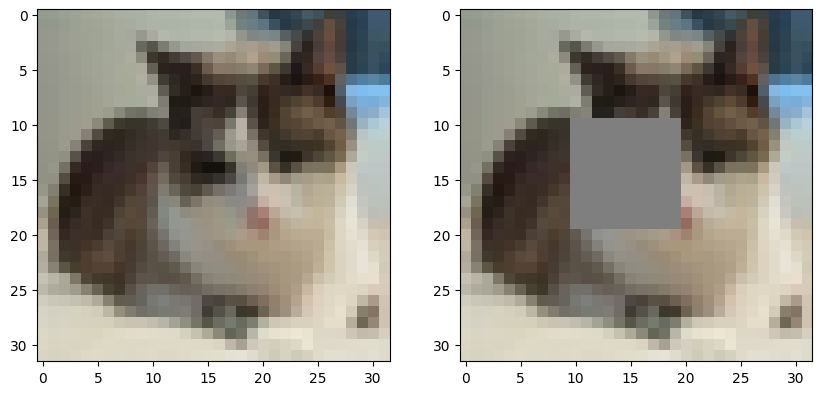

In [15]:
gatto = 3129
patch_image1 = patch_image(test_images[gatto], 10, 10, 10)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_images[3129])
plt.subplot(1, 2, 2)
plt.imshow(patch_image1)
plt.show()

In [19]:
prediction = model.predict(test_images[gatto].reshape(1, 32, 32, 3), verbose=0)
print('Prediction on original image:')
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

Prediction on original image:
cat: 0.8310598134994507
dog: 0.16566582024097443
frog: 0.0021836585365235806
deer: 0.0005938632530160248
bird: 0.000213820138014853


In [20]:
prediction = model.predict(patch_image1.reshape(1, 32, 32, 3), verbose=0)
print('Prediction on patched image:')
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

Prediction on patched image:
cat: 0.669676661491394
dog: 0.29367831349372864
bird: 0.009415562264621258
truck: 0.008858528919517994
frog: 0.006101746577769518


Model has also problem to distinguish between `automobile` and `truck`. The following image is classified correctly as a truck with a probability of 0.99, applying a patch of 15x15 size in the bottom right corner causes the model to misclassify the image as automobile with a probability of 0.64. The applied patch cover the tires, which are a key features of both classes so probably this means that the model use the dimensions of the tires to classify the image as truck. 

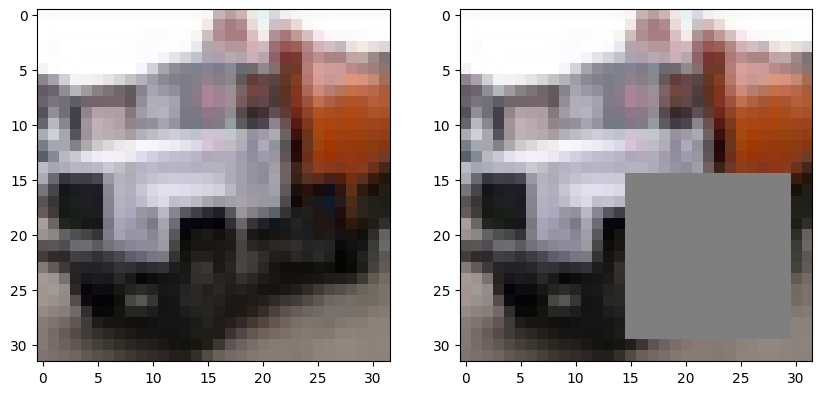

In [13]:
truck = 3409
patch_image2 = patch_image(test_images[3409], 15, 15, 15)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_images[truck])
plt.subplot(1, 2, 2)
plt.imshow(patch_image2)
plt.show()

In [24]:
prediction = model.predict(test_images[truck].reshape(1, 32, 32, 3), verbose=0)
print('Prediction on original image:')
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

Prediction on original image:
truck: 0.9997172951698303
automobile: 0.00028261059196665883
airplane: 5.8283873727305036e-08
ship: 1.4037413897938222e-08
dog: 7.57996443390141e-11


In [25]:
prediction = model.predict(patch_image2.reshape(1, 32, 32, 3))
print('Prediction on patched image:')
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

1/1 [==============================] - 0s 22ms/step
Prediction on patched image:
automobile: 0.6405659317970276
truck: 0.3130090832710266
airplane: 0.04376723989844322
ship: 0.0021947561763226986
horse: 0.00020000821677967906


### Accuracy vs patch size

After the first test we can now check how much the accuracy on test set drops when we occlude part of the image. The following function `occlusion_accuracy()` takes as input the model, the images, the labels and a list of patch sizes, and return a dict with accuracies for every patch size. 

In [8]:
def occlusion_accuracy(model, images, labels, sizes):
    """
    Returns the accuracy of a model on occluded images.

    Args:
        model: trained model
        images: images to be occluded
        labels: labels of the images
        sizes: list of sizes of the patch

    Returns:
        acc_size: dictionary of accuracies for each patch size

    """
    acc_size = {}
    for size in sizes:
        patched_images = []
        for i in range(len(images)):
            patched_images.append(patch_image(images[i], 5, 5, size))

        patched_images = np.array(patched_images)

        test_loss, test_acc = model.evaluate(patched_images, labels, verbose=0)

        acc_size[size] = test_acc

    return acc_size
    

As we can expect the accuracy of the model drops as the patch size increases. The model is able to classify correctly images with a patch of 5x5 size with an accuracy of 0.83, but when the patch size is 15x15 the accuracy drops to 0.67. It seems that patch of size lower than 5x5 do not affect so much the model performance. When the patch became nearly the dimension of the image, the model is not able to recognize the object anymore and the accuracy drops to 0.1.

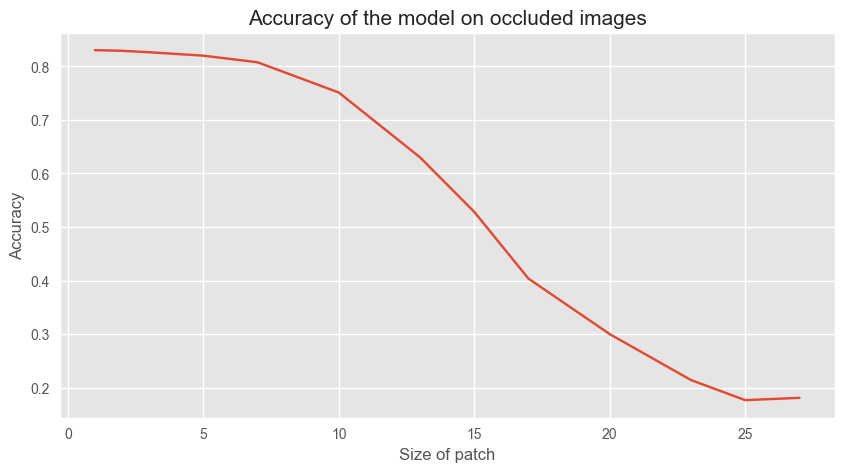

In [37]:
acc_size = occlusion_accuracy(model, test_images, test_labels, [1, 2, 3, 5, 7, 10, 13, 15, 17, 20, 23, 25, 27])

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(acc_size.keys(), acc_size.values())
plt.title('Accuracy of the model on occluded images', size=15)
plt.xlabel('Size of patch')
plt.ylabel('Accuracy')
plt.show()

### Critical pixels

Now we focus on the position of the patch, by sliding a pacth of 1x1 over all the image we can check which pixel is more important for the classification. The function `main_pixels()` takes as input the model, the image and the patch size, and return a dict with the probability of the predicted label for every position of the patch. To find the main pixel of the image we can call the function like this
```python
main_pixels(model, test_images[3129], 1)
```
and then take the pixel with the lowest probability of predicted label. 

In [9]:
def main_pixels(model, image, size):
    """
    Returns the pixel or patch that if occluded will result in the lowest probability of the correct class.

    Args:
        model: trained model
        image: image to be patched
        size: size of patch (1 is a pixel, 2 is a 2x2 patch, etc.)

    Returns:
        (x, y): coordinates of pixel/patch 
    """
    pix_prob = {}
    for j in range(32):
        for k in range(32):

            pp = patch_image(image, j, k, size)
            pp = pp.reshape(1, 32, 32, 3)

            prediction = model.predict(pp, verbose=0)
            prediction_prob = prediction[0][np.argsort(prediction[0])[-1]]
            prediction_name = class_names[np.argmax(prediction)]

            pix_prob[(j, k)] = (prediction_prob, prediction_name)
    
    return pix_prob

#### Cat

In [ ]:
pix_prob = main_pixels(model,test_images[3129],1)

main_pixel = min(pix_prob.items(), key=lambda x: x[1][0])
x,y = main_pixel[0]

In the `cat` image the pixel with coordinates (14, 5) is the one that drop the most the prediction of the model. With only this pixel occluded the model turns from predict the class with 83% probability to 72%. The heatmap shows critical pixels for the classification, where darker pixels are the one that drop the most the probability of predicted label. From the heatmap it seems that the most important pixels are the one on the border of the cat, which makes sense, model doesn't really needs to know how the object is 'filled'. Also darker pixels are the ones representing cat's eyes and ears, which are key features of the class.

((14, 5), (0.72262454, 'cat'))


<Axes: >

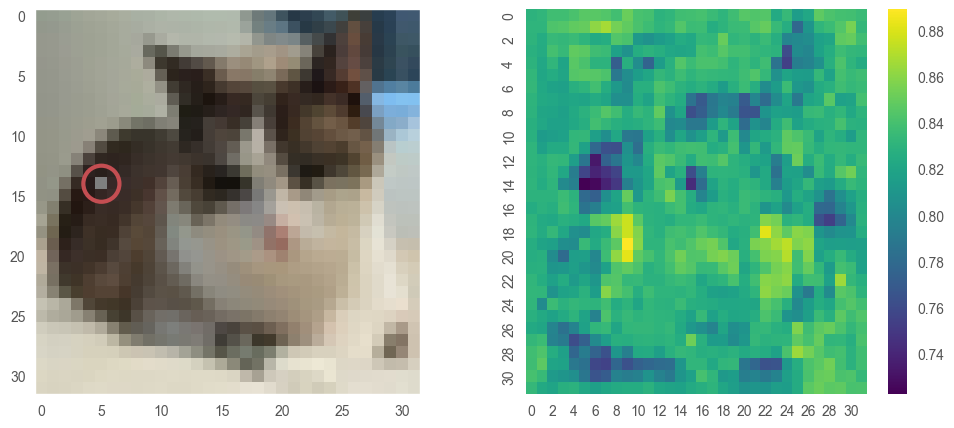

In [65]:
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
circle = plt.Circle((y, x), 1.5, color='r', fill=False, linewidth=3)
plt.gca().add_patch(circle)
plt.grid(False)
plt.imshow(patch_image(test_images[3129], x, y, 1))
pprint(main_pixel)

plt.subplot(1, 2, 2)
plt.subplots_adjust(right=2)
heatmap = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        heatmap[i, j] = pix_prob[(i, j)][0]
sns.heatmap(heatmap, cmap='viridis')

#### Bird

In [97]:
pix_prob2 = main_pixels(model,test_images[8095],1)

main_pixel2 = min(pix_prob2.items(), key=lambda x: x[1][0])
x,y = main_pixel2[0]

Another class which is highly misclassified is `bird`, 75 of them were classified as `frog`. In the following image the model has identify a bird with 99% probability. The heatmap shows how the background doesn't really affect the classification when occluded. The main pixel appear to be the one over the wings of the bird, which is a key feature of the class. It's interesting to see that the critical pixels are not only the ones on the body of the bird, but also the ones representing the branch where the bird is standing. This means that the model is able to recognize the bird also by the context, and not only by the shape of the bird itself.

((16, 20), (0.99990845, 'bird'))


<Axes: >

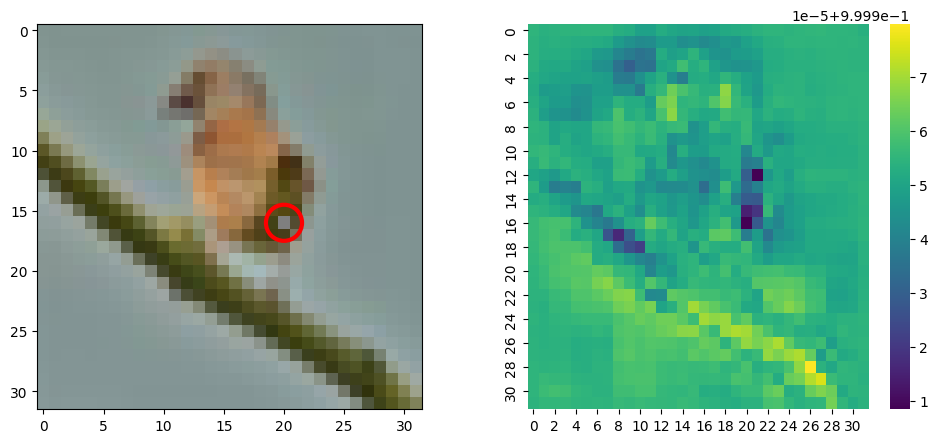

In [98]:
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
circle = plt.Circle((y, x), 1.5, color='r', fill=False, linewidth=3)
plt.gca().add_patch(circle)
plt.grid(False)
plt.imshow(patch_image(test_images[8095], x, y, 1))
pprint(main_pixel2)

plt.subplot(1, 2, 2)
plt.subplots_adjust(right=2)
heatmap = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        heatmap[i, j] = pix_prob2[(i, j)][0]
sns.heatmap(heatmap, cmap='viridis')    

#### Automobile

In [230]:
pix_prob3 = main_pixels(model,test_images[2112],1)

main_pixel3 = min(pix_prob3.items(), key=lambda x: x[1][0])
x,y = main_pixel3[0]

In [257]:
pix_prob4 = main_pixels(model,test_images[2943],1)

main_pixel4 = min(pix_prob4.items(), key=lambda x: x[1][0])
x,y = main_pixel4[0]

The class which the model can recognize better is `automobile`, although is a bit confused with truck and ship, almost all the images are classified correctly. In both the car images the prediction of the model is not affected by pixels on the car itself. Instead, critical pixels seems to be the one representing the shadow of the car on the ground.

((20, 25), (0.96710044, 'automobile'))


<Axes: >

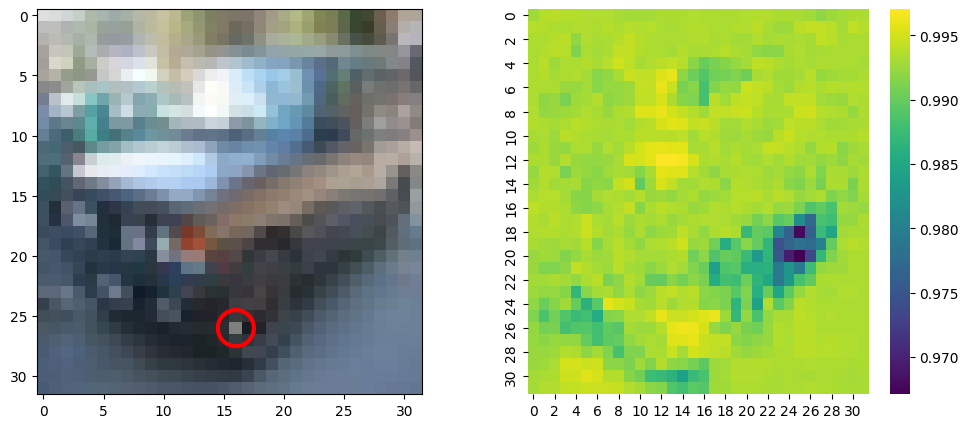

In [273]:
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
circle = plt.Circle((y, x), 1.5, color='r', fill=False, linewidth=3)
plt.gca().add_patch(circle)
plt.grid(False)
plt.imshow(patch_image(test_images[2112], x, y, 1))
pprint(main_pixel3)

plt.subplot(1, 2, 2)
plt.subplots_adjust(right=2)
heatmap = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        heatmap[i, j] = pix_prob3[(i, j)][0]
sns.heatmap(heatmap, cmap='viridis')

((26, 16), (0.5934507, 'automobile'))


<Axes: >

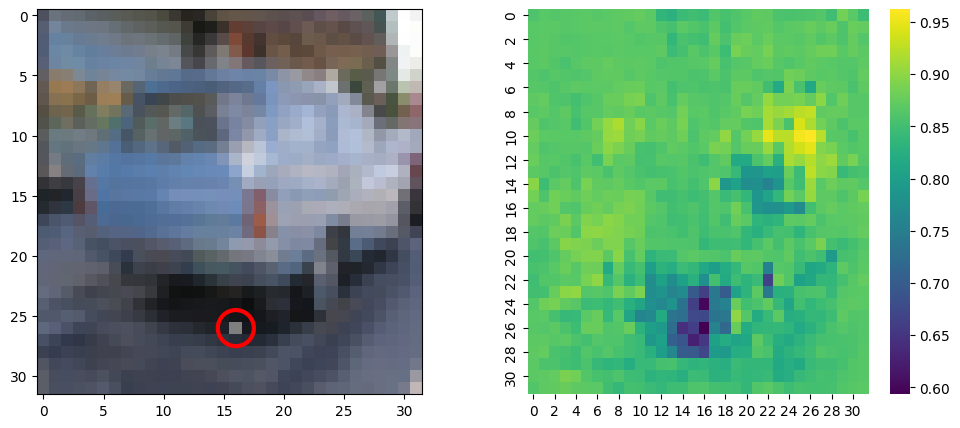

In [258]:
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
circle = plt.Circle((y, x), 1.5, color='r', fill=False, linewidth=3)
plt.gca().add_patch(circle)
plt.grid(False)
plt.imshow(patch_image(test_images[2943], x, y, 1))
pprint(main_pixel4)

plt.subplot(1, 2, 2)
plt.subplots_adjust(right=2)
heatmap = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        heatmap[i, j] = pix_prob4[(i, j)][0]
sns.heatmap(heatmap, cmap='viridis')

#### Deer

In [274]:
deer = 769
pix_prob5 = main_pixels(model,test_images[deer],1)

main_pixel5 = min(pix_prob5.items(), key=lambda x: x[1][0])
x,y = main_pixel5[0]

The heatmap for an image of a deer shows that critical pixels are the ones representing neck, nose and horns. It is also noticeble how the pixels which affect less the model are not the ones representing the background, but the ones representing the lower part of deer body, which problably is not a key feature of the class.

((24, 14), (0.9981402, 'deer'))


<Axes: >

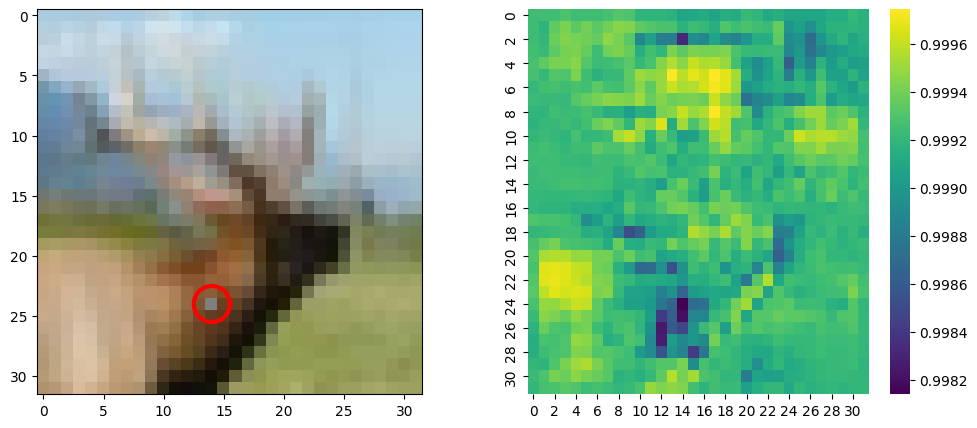

In [275]:
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
circle = plt.Circle((y, x), 1.5, color='r', fill=False, linewidth=3)
plt.gca().add_patch(circle)
plt.grid(False)
plt.imshow(patch_image(test_images[deer], x, y, 1))
pprint(main_pixel5)

plt.subplot(1, 2, 2)
plt.subplots_adjust(right=2)
heatmap = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        heatmap[i, j] = pix_prob5[(i, j)][0]
sns.heatmap(heatmap, cmap='viridis')

#### All classes

Finally we can iterate the process on the test set images to find the critical pixels in general, not on a single class. The function `acc_pixels()` takes as input the model, the images, the labels and the patch size, and return a dict with the accuracy of the model for every position of the patch. For all the pixels `(x,y)` the function `acc_pixels()` apply a patch of size `nxn` to all the images in the list and compute the accuarcy for the position `(x,y)`.

In [259]:
def acc_pixels(model, images, labels, size=1):
    """
    Returns the accuracy of the model on occluded images at each pixel.

    Args:
        model: trained model
        images: images to be occluded
        labels: labels of the images
        size: size of patch (1 is a pixel, 2 is a 2x2 patch, etc.)

    Returns:
        pix_acc: dictionary of accuracies for each pixel
    """
    pix_acc = {}
    for i in range(32):
        for j in range(32):
            # occlude all test images at pixel (i, j)
            patched_images = []
            for z in range(len(images)):
                patched_images.append(patch_image(images[z], i, j, size))

            patched_images = np.array(patched_images)
            test_loss, test_acc = model.evaluate(patched_images, labels, verbose=0)

            pix_acc[(i, j)] = test_acc
    
    return pix_acc

Due to the nested loops the function takes 43 minutes to run over the entire test set (10.000 images). For this reason the following cell is commented, the results are saved in a pickle file and loaded in the next cell.

In [262]:
#pix_acc = acc_pixels(model, test_images, test_labels, 1)

import pickle
#with open('pix_acc.pickle', 'wb') as handle:
#    pickle.dump(pix_acc, handle, protocol=pickle.HIGHEST_PROTOCOL)


As we could expect the pixels which drop the most the accuracy if occluded are the one in the center of the image. It's not surprising also that the accuracy drops of few points, a single pixel occluded is not enough to change the prediction of the model. This heatmap looks more confused than the previous ones, this is because now we are looking to all classes and previously we see how different classes have different critical pixels. However it's an interesting overview of the pixels which can cause more damage to the model if occluded.

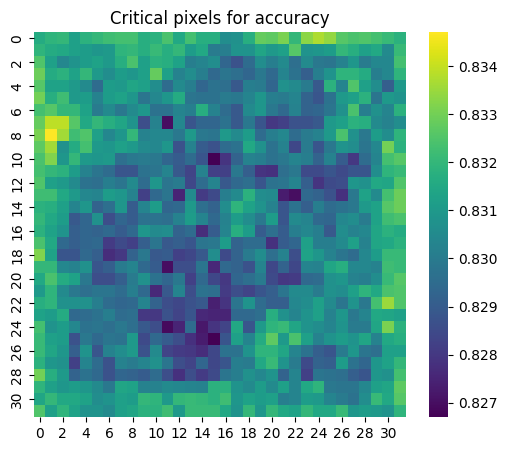

In [267]:
loaded_pix_acc = {}
with open('pix_acc.pickle', 'rb') as handle:
    loaded_pix_acc = pickle.load(handle)

plt.figure(figsize=(6,5))
prova = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        prova[i, j] = loaded_pix_acc[(i, j)]
sns.heatmap(prova, cmap='viridis')
plt.title('Critical pixels for accuracy', size=12)
plt.show()

## Final Considerations


For this assignment i started by defining and train my own Convolutional Neural Network. After applying some regularization techniques the model was able to reach an accuracy of 83% on the test set, which is a good result. Then i tested the model with occluded images, and i found that the accuracy drops as the patch size increases. I also found critical pixels for some images of the most and less misclassified classes, and i found that the model is able to recognize the object also by the context, not only by the shape of the object itself. Finally the last heatmap gives a visual representation of the pixels which drop the most the accuracy if occluded.

In the notebook i used the libraries [keras](https://keras.io/api/) to define and train the model, [matplotlib](https://matplotlib.org) and [seaborn](https://seaborn.pydata.org) to plot the images and the heatmaps, [numpy](https://numpy.org) to manipulate the images.

I choose this assignment because in the first two i didn't use images, so i wanted to experiment with it. CNNs are also one of the main topics of the course and i wanted to take confidence with their usage. I found this assignment very interesting and i learned a lot from it, in particular i really liked to see how the CNNs 'reason' about the images, and how they can be fooled by occluding part of the image.

Further analysis can be done on other classes, using different pacth shape, color or size and compare the results.